### Prediction Nueral Network | Keras Framework
- [Article Link](https://www.kaggle.com/youssefhesham8/chrun-bank-data-with-simple-ann)
- [Keras](https://keras.io/api/models/sequential/)

#### Problem: Can a model be developed to predict churn of customers?

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from tensorflow import keras
import shap
from tensorflow.keras import models, layers, utils, backend as K
import seaborn as sns
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import shap
from imblearn.over_sampling import SMOTE

In [2]:
df = pd.read_csv(r'C:\Data Sciences\Data\all_data_files\Churn_Modelling.csv')
print('\nDateframe Shape: ', {df.shape})

df.drop(['RowNumber', 'CustomerId', 'Surname'], axis = 1, inplace=True)

for i in df.columns:
    if i != 'CreditScore':
       print(f"{i} -> {df[i].unique()}")

df['Gender'] = df['Gender'].replace({'Male':1 , 'Female':0})
df = pd.get_dummies(data = df, columns=['Geography'])

for i in df.columns:
    if i != 'CreditScore':
       print(f"{i} -> {df[i].unique()}")

df.describe().transpose()

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Data Sciences\\Data\\all_data_files\\Churn_Modelling.csv'

<AxesSubplot:xlabel='Balance'>

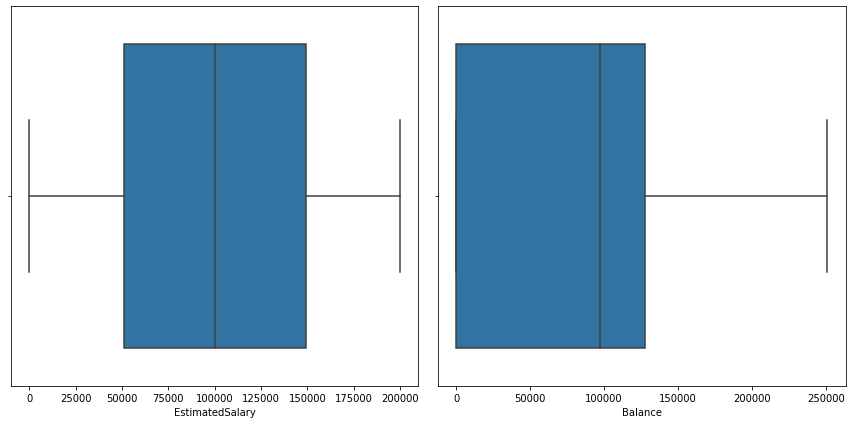

In [ ]:
plt.rcParams["figure.figsize"] = [12,6] 
plt.rcParams["figure.autolayout"] = True 

fig, axes = plt.subplots(1, 2)
sns.boxplot(x = df['EstimatedSalary'], ax = axes[0],  showfliers = True)  
sns.boxplot(x = df['Balance'] , ax = axes[1], showfliers = True )

In [ ]:
scale = Normalizer()
lis = ['Age','CreditScore' , 'Balance', 'EstimatedSalary']
df[lis] = scale.fit_transform(df[lis])
df.head(3)

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain
0,0.006108,0,0.000414,2,0.000000,1,1,1,0.999981,1,1,0,0
1,0.004333,0,0.000292,1,0.597258,1,0,1,0.802037,0,0,0,1
2,0.002559,0,0.000214,8,0.814000,3,1,0,0.580859,1,1,0,0


In [ ]:
df['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

In [ ]:
df['Exited'].value_counts(normalize=True)

0    0.7963
1    0.2037
Name: Exited, dtype: float64

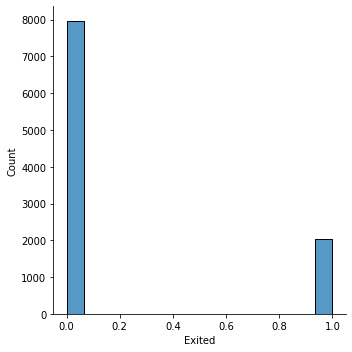

In [ ]:
sns.displot(df['Exited'])

In [ ]:
sam = SMOTE(sampling_strategy='minority')

X = df.drop('Exited', axis = 1)
Y = df['Exited']

x_smote, y_smote = sam.fit_resample(X,Y)
x_train, x_test, y_train, y_test = train_test_split(x_smote, y_smote,test_size= 0.2, stratify= y_smote)

my_callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor = 'loss', patience=3),
    tf.keras.callbacks.CSVLogger('model_logger.csv', separator = ",", append=False),
#    tf.keras.callbacks.TensorBoard(log_dir= './logs'),
]

mod_1 = tf.keras.Sequential([
        tf.keras.layers.Dense(5, input_dim = len(x_train.columns), activation = 'relu'),
        tf.keras.layers.Dense(2, activation = 'relu', use_bias=True),
        tf.keras.layers.Dense(1, activation = 'sigmoid')
    ])

#mod_1 = tf.keras.models.Sequential()
#mod_1.add(tf.keras.layers.Dense(8, input_shape=(12,)))
#mod_1.add(tf.keras.layers.Dense(5))
#mod_1.add(tf.keras.layers.Dense(1))

def model_nn(x_train, x_test, y_train, y_test):

    mod = mod_1    
    mod.compile(optimizer='adam', loss='binary_crossentropy', metrics = ['accuracy'])    
    mod.fit(x_train, y_train, batch_size=32, epochs = 100, verbose = 0, callbacks = [my_callbacks])
    mod.summary()
    
    print(f'\n test accuracy -> {mod.evaluate(x_test, y_test)}')

    y_pred = mod.predict(x_test)
    y_pred = np.round(y_pred)
    
    return y_pred

y_pred = model_nn(x_train, x_test, y_train, y_test)

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_78 (Dense)            (None, 5)                 65        
                                                                 
 dense_79 (Dense)            (None, 2)                 12        
                                                                 
 dense_80 (Dense)            (None, 1)                 3         
                                                                 
Total params: 80
Trainable params: 80
Non-trainable params: 0
_________________________________________________________________
100/100 [==============================] - 0s 2ms/step - loss: 0.5217 - accuracy: 0.7332

 test accuracy -> [0.5217363834381104, 0.7332077622413635]


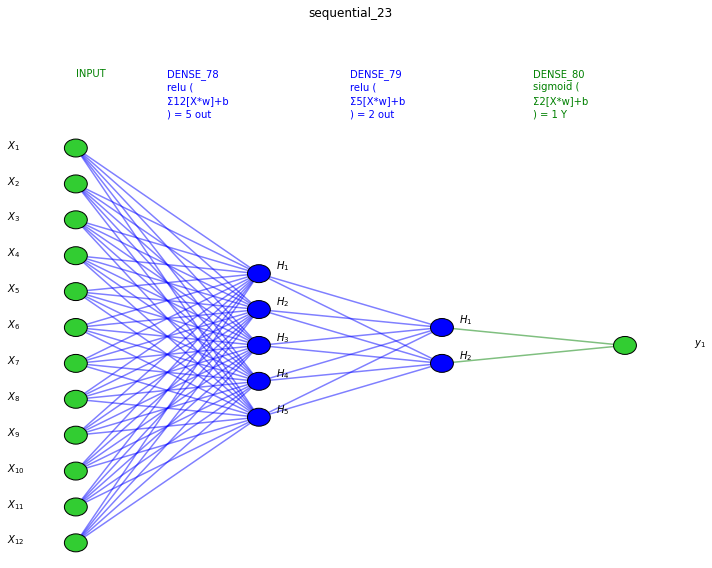

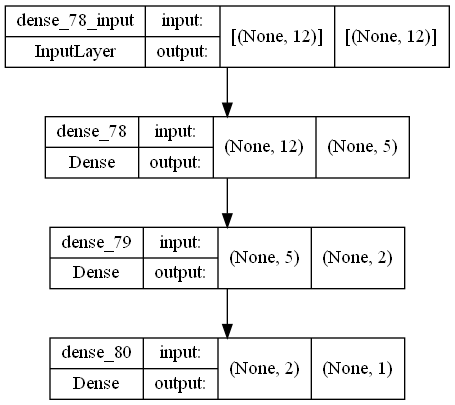

In [ ]:
'''
Extract info for each layer in a keras model.
'''
def utils_nn_config(mod_1):
    lst_layers = []
    if "Sequential" in str(mod_1): #-> Sequential doesn't show the input layer
        layer = mod_1.layers[0]
        lst_layers.append({"name":"input", "in":int(layer.input.shape[-1]), "neurons":0, 
                           "out":int(layer.input.shape[-1]), "activation":None,
                           "params":0, "bias":0})
    for layer in mod_1.layers:
        try:
            dic_layer = {"name":layer.name, "in":int(layer.input.shape[-1]), "neurons":layer.units, 
                         "out":int(layer.output.shape[-1]), "activation":layer.get_config()["activation"],
                         "params":layer.get_weights()[0], "bias":layer.get_weights()[1]}
        except:
            dic_layer = {"name":layer.name, "in":int(layer.input.shape[-1]), "neurons":0, 
                         "out":int(layer.output.shape[-1]), "activation":None,
                         "params":0, "bias":0}
        lst_layers.append(dic_layer)
    return lst_layers

'''
Plot the structure of a keras neural network.
'''
def visualize_nn(mod_1, description=False, figsize=(10,8)):
    ## get layers info
    lst_layers = utils_nn_config(mod_1)
    layer_sizes = [layer["out"] for layer in lst_layers]
    
    ## fig setup
    fig = plt.figure(figsize=figsize)
    ax = fig.gca()
    ax.set(title=mod_1.name)
    ax.axis('off')
    left, right, bottom, top = 0.1, 0.9, 0.1, 0.9
    x_space = (right-left) / float(len(layer_sizes)-1)
    y_space = (top-bottom) / float(max(layer_sizes))
    p = 0.025
    
    ## nodes
    for i,n in enumerate(layer_sizes):
        top_on_layer = y_space*(n-1)/2.0 + (top+bottom)/2.0
        layer = lst_layers[i]
        color = "green" if i in [0, len(layer_sizes)-1] else "blue"
        color = "red" if (layer['neurons'] == 0) and (i > 0) else color
        
        ### add description
        if (description is True):
            d = i if i == 0 else i-0.5
            if layer['activation'] is None:
                plt.text(x=left+d*x_space, y=top, fontsize=10, color=color, s=layer["name"].upper())
            else:
                plt.text(x=left+d*x_space, y=top, fontsize=10, color=color, s=layer["name"].upper())
                plt.text(x=left+d*x_space, y=top-p, fontsize=10, color=color, s=layer['activation']+" (")
                plt.text(x=left+d*x_space, y=top-2*p, fontsize=10, color=color, s="Σ"+str(layer['in'])+"[X*w]+b")
                out = " Y"  if i == len(layer_sizes)-1 else " out"
                plt.text(x=left+d*x_space, y=top-3*p, fontsize=10, color=color, s=") = "+str(layer['neurons'])+out)
        
        ### circles
        for m in range(n):
            color = "limegreen" if color == "green" else color
            circle = plt.Circle(xy=(left+i*x_space, top_on_layer-m*y_space-4*p), radius=y_space/4.0, color=color, ec='k', zorder=4)
            ax.add_artist(circle)
            
            ### add text
            if i == 0:
                plt.text(x=left-4*p, y=top_on_layer-m*y_space-4*p, fontsize=10, s=r'$X_{'+str(m+1)+'}$')
            elif i == len(layer_sizes)-1:
                plt.text(x=right+4*p, y=top_on_layer-m*y_space-4*p, fontsize=10, s=r'$y_{'+str(m+1)+'}$')
            else:
                plt.text(x=left+i*x_space+p, y=top_on_layer-m*y_space+(y_space/8.+0.01*y_space)-4*p, fontsize=10, s=r'$H_{'+str(m+1)+'}$')
    
    ## links
    for i, (n_a, n_b) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
        layer = lst_layers[i+1]
        color = "green" if i == len(layer_sizes)-2 else "blue"
        color = "red" if layer['neurons'] == 0 else color
        layer_top_a = y_space*(n_a-1)/2. + (top+bottom)/2. -4*p
        layer_top_b = y_space*(n_b-1)/2. + (top+bottom)/2. -4*p
        for m in range(n_a):
            for o in range(n_b):
                line = plt.Line2D([i*x_space+left, (i+1)*x_space+left], 
                                  [layer_top_a-m*y_space, layer_top_b-o*y_space], 
                                  c=color, alpha=0.5)
                if layer['activation'] is None:
                    if o == m:
                        ax.add_artist(line)
                else:
                    ax.add_artist(line)
    plt.show()

visualize_nn(mod_1, description=True, figsize=(10,8))

utils.plot_model(mod_1, to_file='model.png', show_shapes=True, show_layer_names=True)

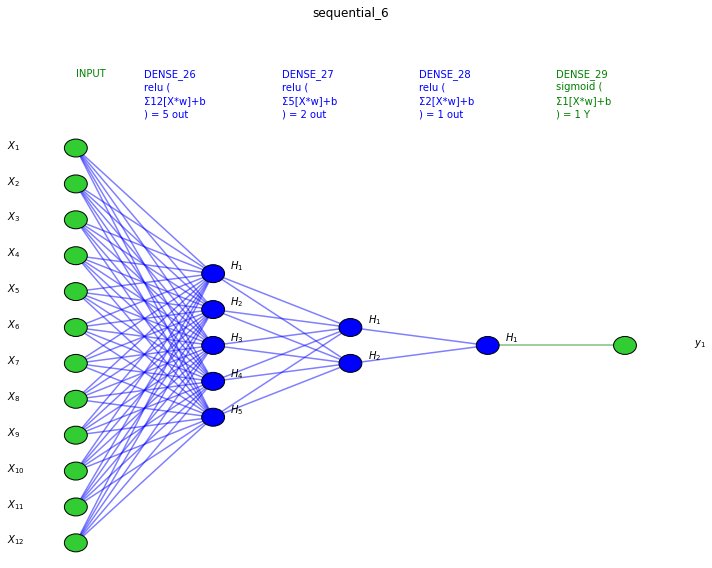

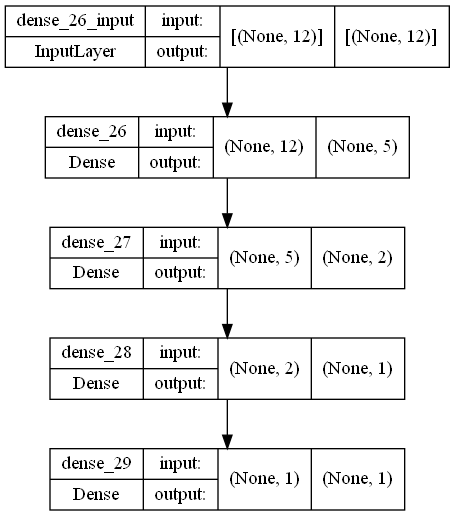

In [ ]:
visualize_nn(mod, description=True, figsize=(10,8))

utils.plot_model(mod, to_file='model.png', show_shapes=True, show_layer_names=True)

report               precision    recall  f1-score   support

           0       0.81      0.74      0.77      1593
           1       0.76      0.82      0.79      1593

    accuracy                           0.78      3186
   macro avg       0.78      0.78      0.78      3186
weighted avg       0.78      0.78      0.78      3186



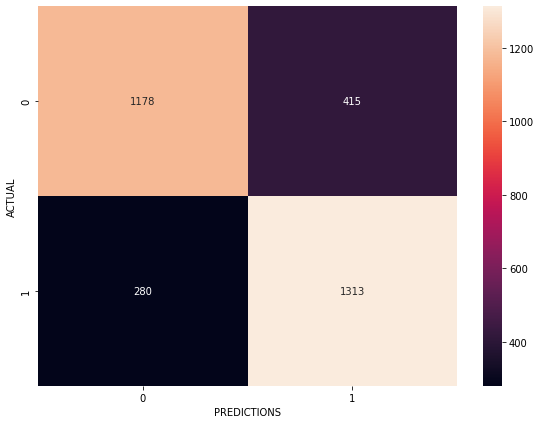

In [ ]:
con = tf.math.confusion_matrix(labels = y_test, predictions = y_pred)
print(f'report {classification_report(y_test, y_pred)}')

plt.figure(figsize=(8,6))
sns.heatmap(con, annot = True, fmt = "d")
plt.xlabel("PREDICTIONS")
plt.ylabel("ACTUAL")
plt.show()

In [ ]:
sam_2 = SMOTE(sampling_strategy='minority')

X = df.drop('Exited', axis = 1)
Y = df['Exited']

x_smote_2, y_smote_2 = sam_2.fit_resample(X, Y)
x_train, x_test, y_train, y_test = train_test_split(x_smote_2, y_smote_2, test_size = 0.2, stratify = y_smote)

N_FEATURES = len(x_train.columns)

model = models.Sequential(name="DeepNN", layers=[
    layers.Dense(name="h1", input_dim=N_FEATURES,
                 units=int(round((N_FEATURES+1)/2)), 
                 activation='relu'),
    layers.Dropout(name="drop1", rate=0.2),
    layers.Dense(name="h2", units=int(round((N_FEATURES+1)/4)), 
                 activation='relu'),
#    layers.Dropout(name="drop2", rate=0.2),
    layers.Dense(name="output", units=1, activation='sigmoid')
])

model.summary()

'''
Extract info for each layer in a keras model.
'''
def utils_nn_config(model):
    lst_layers = []
    if "Sequential" in str(model): #-> Sequential doesn't show the input layer
        layer = model.layers[0]
        lst_layers.append({"name":"input", "in":int(layer.input.shape[-1]), "neurons":0, 
                           "out":int(layer.input.shape[-1]), "activation":None,
                           "params":0, "bias":0})
    for layer in model.layers:
        try:
            dic_layer = {"name":layer.name, "in":int(layer.input.shape[-1]), "neurons":layer.units, 
                         "out":int(layer.output.shape[-1]), "activation":layer.get_config()["activation"],
                         "params":layer.get_weights()[0], "bias":layer.get_weights()[1]}
        except:
            dic_layer = {"name":layer.name, "in":int(layer.input.shape[-1]), "neurons":0, 
                         "out":int(layer.output.shape[-1]), "activation":None,
                         "params":0, "bias":0}
        lst_layers.append(dic_layer)
    return lst_layers

'''
Plot the structure of a keras neural network.
'''
def visualize_nn(model, description=False, figsize=(10,8)):
    ## get layers info
    lst_layers = utils_nn_config(model)
    layer_sizes = [layer["out"] for layer in lst_layers]
    
    ## fig setup
    fig = plt.figure(figsize=figsize)
    ax = fig.gca()
    ax.set(title=model.name)
    ax.axis('off')
    left, right, bottom, top = 0.1, 0.9, 0.1, 0.9
    x_space = (right-left) / float(len(layer_sizes)-1)
    y_space = (top-bottom) / float(max(layer_sizes))
    p = 0.025
    
    ## nodes
    for i,n in enumerate(layer_sizes):
        top_on_layer = y_space*(n-1)/2.0 + (top+bottom)/2.0
        layer = lst_layers[i]
        color = "green" if i in [0, len(layer_sizes)-1] else "blue"
        color = "red" if (layer['neurons'] == 0) and (i > 0) else color
        
        ### add description
        if (description is True):
            d = i if i == 0 else i-0.5
            if layer['activation'] is None:
                plt.text(x=left+d*x_space, y=top, fontsize=10, color=color, s=layer["name"].upper())
            else:
                plt.text(x=left+d*x_space, y=top, fontsize=10, color=color, s=layer["name"].upper())
                plt.text(x=left+d*x_space, y=top-p, fontsize=10, color=color, s=layer['activation']+" (")
                plt.text(x=left+d*x_space, y=top-2*p, fontsize=10, color=color, s="Σ"+str(layer['in'])+"[X*w]+b")
                out = " Y"  if i == len(layer_sizes)-1 else " out"
                plt.text(x=left+d*x_space, y=top-3*p, fontsize=10, color=color, s=") = "+str(layer['neurons'])+out)
        
        ### circles
        for m in range(n):
            color = "limegreen" if color == "green" else color
            circle = plt.Circle(xy=(left+i*x_space, top_on_layer-m*y_space-4*p), radius=y_space/4.0, color=color, ec='k', zorder=4)
            ax.add_artist(circle)
            
            ### add text
            if i == 0:
                plt.text(x=left-4*p, y=top_on_layer-m*y_space-4*p, fontsize=10, s=r'$X_{'+str(m+1)+'}$')
            elif i == len(layer_sizes)-1:
                plt.text(x=right+4*p, y=top_on_layer-m*y_space-4*p, fontsize=10, s=r'$y_{'+str(m+1)+'}$')
            else:
                plt.text(x=left+i*x_space+p, y=top_on_layer-m*y_space+(y_space/8.+0.01*y_space)-4*p, fontsize=10, s=r'$H_{'+str(m+1)+'}$')
    
    ## links
    for i, (n_a, n_b) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
        layer = lst_layers[i+1]
        color = "green" if i == len(layer_sizes)-2 else "blue"
        color = "red" if layer['neurons'] == 0 else color
        layer_top_a = y_space*(n_a-1)/2. + (top+bottom)/2. -4*p
        layer_top_b = y_space*(n_b-1)/2. + (top+bottom)/2. -4*p
        for m in range(n_a):
            for o in range(n_b):
                line = plt.Line2D([i*x_space+left, (i+1)*x_space+left], 
                                  [layer_top_a-m*y_space, layer_top_b-o*y_space], 
                                  c=color, alpha=0.5)
                if layer['activation'] is None:
                    if o == m:
                        ax.add_artist(line)
                else:
                    ax.add_artist(line)
    plt.show()

Model: "DeepNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 h1 (Dense)                  (None, 6)                 78        
                                                                 
 drop1 (Dropout)             (None, 6)                 0         
                                                                 
 h2 (Dense)                  (None, 3)                 21        
                                                                 
 output (Dense)              (None, 1)                 4         
                                                                 
Total params: 103
Trainable params: 103
Non-trainable params: 0
_________________________________________________________________


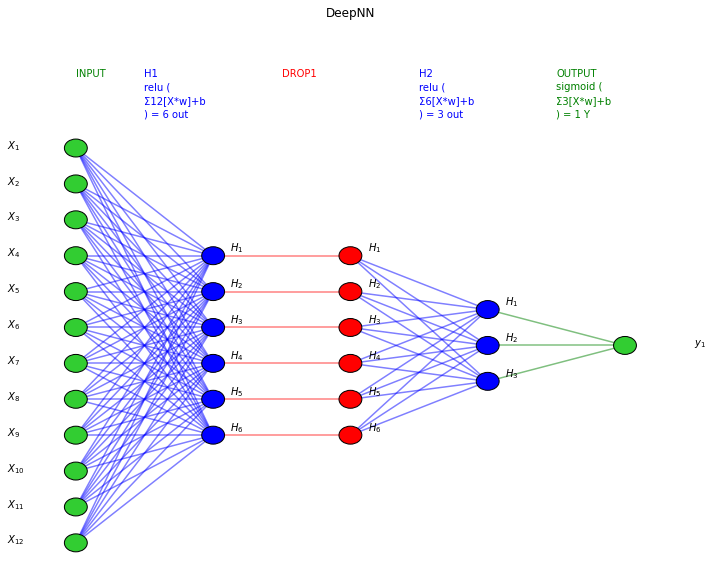

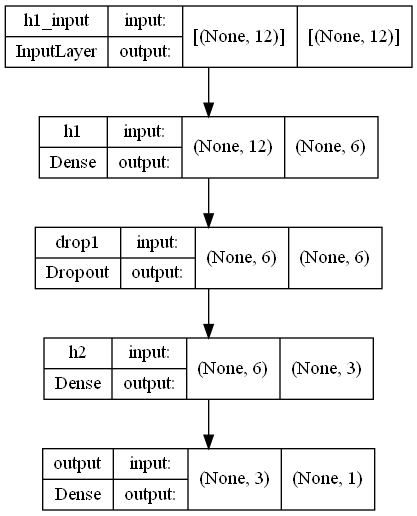

In [ ]:
visualize_nn(model, description=True, figsize=(10,8))

utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [ ]:
my_callbacks_2 = [
    tf.keras.callbacks.EarlyStopping(monitor = 'loss', patience = 5),
    tf.keras.callbacks.CSVLogger('model_logger_2.csv', separator = ",", append=False),
#    tf.keras.callbacks.TensorBoard(log_dir= './logs'),
]

model.compile(optimizer='adam', loss='binary_crossentropy', metrics = ['accuracy'])

training = model.fit(x_train, y_train, batch_size = 32, epochs = 50, shuffle = True, verbose = 0, validation_split = 0.2, callbacks = [my_callbacks_2])

print(f'\n test accuracy -> {model.evaluate(x_test, y_test)}')
print('COMPLETED')

In [ ]:
y_pred = model.predict(x_test)
y_pred = np.round(y_pred)

con_2 = tf.math.confusion_matrix(labels = y_test, predictions = y_pred)
print(f'report {classification_report(y_test, y_pred)}')

plt.figure(figsize=(8,6))
sns.heatmap(con_2, annot = True, fmt = "d")
plt.xlabel("PREDICTIONS")
plt.ylabel("ACTUAL")
plt.title("NN_MODEL_2")
plt.show()

In [ ]:
# plot
metrics = [k for k in training.history.keys() if ("loss" not in k) and ("val" not in k)]    
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(15,3))

## training    
ax[0].set(title="Training")
ax11 = ax[0].twinx()
ax[0].plot(training.history['loss'], color='black')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss', color='black')
 
for metric in metrics:        
    ax11.plot(training.history[metric], label=metric)
    ax11.set_ylabel("Score", color='steelblue')
ax11.legend()

## validation    
ax[1].set(title="Validation")
ax22 = ax[1].twinx()
ax[1].plot(training.history['val_loss'], color='black')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss', color='black')

for metric in metrics:          
    ax22.plot(training.history['val_'+metric], label=metric)
    ax22.set_ylabel("Score", color="steelblue")
plt.show()